# Truth Social Network Structure Analysis

## Imports

In [1]:
import mysql.connector
import pandas as pd
import networkx as nx
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [2]:
import matplotlib as mpl 

mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12 
mpl.rcParams['ytick.labelsize'] = 12  

In [3]:
psw = ''

conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root', 
    password = psw,
    database = 'truth_social')

cursor = conn.cursor()

## Get Data

In [4]:
cursor.execute("SELECT * FROM truths")
headers = [column[0] for column in cursor.description]
truths = pd.DataFrame(cursor.fetchall(), columns=headers)
truths.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id
0,18,2022-09-11 20:24:00,2022-09-14 17:27:43,0,0,26,12300,2760,590,"On this day, let’s also never forget those who...",https://truthsocial.com/@EricTrump/posts/10898...,-1,108982585515785274
1,21,2022-07-30 19:05:00,2022-09-14 20:54:37,0,0,26,5660,789,346,#LIVGolf is off the charts! @TrumpBedminster,https://truthsocial.com/@EricTrump/posts/10873...,-1,108738795367938727
2,26,2022-06-22 09:47:00,2022-09-14 22:11:40,1,0,26,0,0,0,The deal on “Gun Control” currently being stru...,https://truthsocial.com/@EricTrump/posts/10852...,2420,108527713196735892
3,29,2022-08-19 18:24:00,2022-09-14 22:30:01,0,0,26,15700,3320,1110,<emoji: us><emoji: us><emoji: us>,https://truthsocial.com/@EricTrump/posts/10885...,-1,108851881295512464
4,34,2022-05-13 13:58:00,2022-09-14 22:57:18,0,1,26,2640,401,67,See you soon!!!,https://truthsocial.com/@EricTrump/posts/10829...,-1,108295925937467612


In [5]:
cursor.execute("SELECT * FROM users")
headers = [column[0] for column in cursor.description]
users = pd.DataFrame(cursor.fetchall(), columns=headers)
users.head()

,id,timestamp,time_scraped,username,follower_count,following_count,profile_url,finished_follower_scrape,finished_following_scrape,finished_truth_scrape
0,22,2022-05-01,2022-09-04 23:14:03,ProjectVeritasAction,455386.0,2.0,https://truthsocial.com/@ProjectVeritasAction,1.0,1.0,1.0
1,23,2022-05-01,2022-09-04 23:32:45,ProjectVeritas,617923.0,15.0,https://truthsocial.com/@ProjectVeritas,1.0,1.0,1.0
2,24,2022-05-01,2022-09-04 23:32:57,JamesOKeefeIII,395827.0,5.0,https://truthsocial.com/@JamesOKeefeIII,1.0,1.0,1.0
3,25,2022-02-01,2022-09-04 23:34:48,JCSullivan,6942.0,221.0,https://truthsocial.com/@JCSullivan,0.0,0.0,0.0
4,26,2022-02-01,2022-09-04 23:48:56,EricTrump,1727967.0,178.0,https://truthsocial.com/@EricTrump,1.0,1.0,0.0


In [6]:
users['username'].fillna("NaN", inplace=True)

## Network Graph

In [7]:
G = nx.DiGraph()

# Adding nodes (users).
for _, user in users.iterrows():
    G.add_node(user['id'], nickname=user['username'])

In [8]:
# Adding edges
retruths = truths[truths['is_retruth'] == 1]
for _, truth in retruths.iterrows():
    original_post_id = truth['truth_retruthed']
    res = truths.loc[truths['id'] == original_post_id, 'author']
    # If Truth retruthed is on dataset
    if not res.empty:
        original_author_id = res.item()
        # Add directed edge from repost author to original author
        G.add_edge(truth['author'], original_author_id)

In [9]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 454458
Number of edges: 105601


In [10]:
# In degree
in_degrees = dict(G.in_degree())
max_in_degree_node = max(in_degrees, key=in_degrees.get)
max_in_degree_count = in_degrees[max_in_degree_node]

# Agora você pode acessar o vértice com o maior in_degree e o número real de arestas que entram.
print(f"O vértice com o maior in_degree é: {max_in_degree_node}")
print(f"Número real de arestas que entram: {max_in_degree_count}")

# Se desejar, você pode obter informações adicionais sobre o vértice, como o nickname.
print(f"Nickname do vértice com o maior in_degree: {G.nodes[max_in_degree_node]['nickname']}")

O vértice com o maior in_degree é: 27
Número real de arestas que entram: 1446
Nickname do vértice com o maior in_degree: realDonaldTrump


In [11]:
out_degrees = dict(G.out_degree())
max_out_degree_node = max(out_degrees, key=out_degrees.get)
max_out_degree_count = out_degrees[max_out_degree_node]

# Agora você pode acessar o vértice com o maior in_degree e o número real de arestas que entram.
print(f"O vértice com o maior out_degree é: {max_out_degree_node}")
print(f"Número real de arestas que saem: {max_out_degree_count}")

# Se desejar, você pode obter informações adicionais sobre o vértice, como o nickname.
print(f"Nickname do vértice com o maior out_degree: {G.nodes[max_out_degree_node]['nickname']}")

O vértice com o maior out_degree é: 12524
Número real de arestas que saem: 914
Nickname do vértice com o maior out_degree: NavyCMC


In [12]:
# In degree centrality
in_degree_centrality = nx.in_degree_centrality(G)
max_in_degree_node = max(in_degree_centrality, key=in_degree_centrality.get)

print(f"Author with most in degree centrality: {max_in_degree_node}")
print(f"In degree Centrality: {in_degree_centrality[max_in_degree_node]}")
print(f"Username: {G.nodes[max_in_degree_node]['nickname']}")

Author with most in degree centrality: 27
In degree Centrality: 0.0031818191820128195
Username: realDonaldTrump


### Saving Graph

In [13]:
nx.write_graphml(G, "grafo_gephi.graphml")

### Degree Distribution

In [196]:
in_degrees = list(dict(G.in_degree()).values())
out_degrees = list(dict(G.out_degree()).values())
total_nodes = len(G)

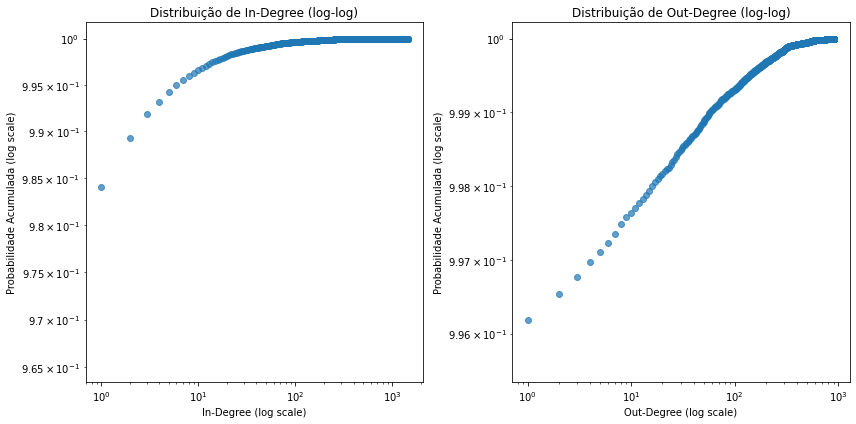

In [16]:
# In degree and out degree histograms
in_degree_hist = np.bincount(in_degrees)
out_degree_hist = np.bincount(out_degrees)

# Cumulative probabilities 
in_degree_cdf = np.cumsum(in_degree_hist) / np.sum(in_degree_hist)
out_degree_cdf = np.cumsum(out_degree_hist) / np.sum(out_degree_hist)

# Cumulative distribution for in degree
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(range(len(in_degree_cdf)), in_degree_cdf, marker='o', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Distribuição de In-Degree (log-log)")
plt.xlabel("In-Degree (log scale)")
plt.ylabel("Probabilidade Acumulada (log scale)")

# Cumulative distribution for out degree
plt.subplot(122)
plt.scatter(range(len(out_degree_cdf)), out_degree_cdf, marker='o', alpha=0.7)
plt.xscale('log')
plt.yscale('log')
plt.title("Distribuição de Out-Degree (log-log)")
plt.xlabel("Out-Degree (log scale)")
plt.ylabel("Probabilidade Acumulada (log scale)")

plt.tight_layout()
plt.show()

In [331]:
def power_law(x, a, b):
    return a * x**b

In [332]:
# In degree and out degree histograms
in_degree_hist, in_degree_bins = np.histogram(in_degrees, bins=10000, density=True)
out_degree_hist, out_degree_bins = np.histogram(out_degrees, bins=10000, density=True)

# Mean points of each bin
in_degree_bins_mid = 0.5 * (in_degree_bins[:-1] + in_degree_bins[1:])
out_degree_bins_mid = 0.5 * (out_degree_bins[:-1] + out_degree_bins[1:])

# Fitting power law
X = in_degree_bins_mid[1:]
Y = in_degree_hist[1:]
params, cov = curve_fit(power_law, X, Y)
a, b = params

In [338]:
X_in_plot = np.linspace(1, 300, 100)
Y_in_plot = power_law(X_in_plot, 0.07, -1.6)

In [339]:
X_out_plot = np.linspace(1, 300, 100)
Y_out_plot = power_law(X_out_plot, 0.007, -0.9)

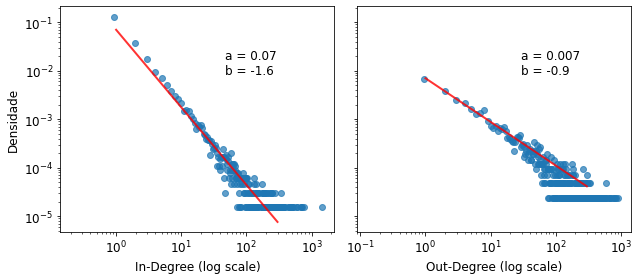

In [340]:
# Scatter plot of in degree distribution
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax[0].scatter(in_degree_bins_mid[1:], in_degree_hist[1:], marker='o', alpha=0.7)
ax[0].plot(X_in_plot, Y_in_plot, c='r', alpha=0.8, linewidth=2)
ax[0].annotate(f'a = 0.07\nb = -1.6', xy=(0.6, 0.7), xycoords='axes fraction', fontsize=12)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("In-Degree (log scale)")
ax[0].set_ylabel("Densidade")

# Scatter plot of out degree distribution
ax[1].scatter(out_degree_bins_mid[1:], out_degree_hist[1:], marker='o', alpha=0.7)
ax[1].plot(X_out_plot, Y_out_plot, c='r', alpha=0.8, linewidth=2)
ax[1].annotate(f'a = 0.007\nb = -0.9', xy=(0.6, 0.7), xycoords='axes fraction', fontsize=12)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("Out-Degree (log scale)")
#plt.ylabel("Densidade (log scale)")

plt.tight_layout()
plt.show()

### Strongly Connected Components

In [16]:
strongly_connected_components = list(nx.strongly_connected_components(G))
num_strongly_connected_components = len(strongly_connected_components)

print(f"Number of Strongly Connected Components: {num_strongly_connected_components}")

Number of Strongly Connected Components: 454095


In [17]:
largest_strongly_connected_component = max(strongly_connected_components, key=len)
num_nodes_largest_component = len(largest_strongly_connected_component)

print(f"Largest SCC size: {num_nodes_largest_component}")

Largest SCC size: 361


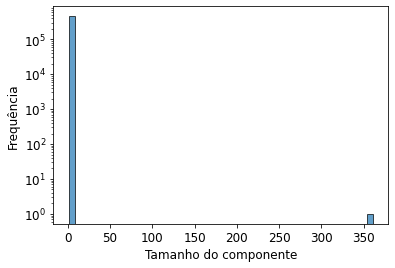

In [18]:
SCC_sizes = [len(SCC) for SCC in strongly_connected_components]

plt.figure(figsize=(6, 4))
plt.hist(SCC_sizes, bins=50, alpha=0.7, edgecolor='k')
#plt.title("Distribuição dos Coeficientes de Clusterização")
plt.xlabel("Tamanho do componente")
plt.ylabel("Frequência")
plt.yscale('log')
plt.show()

In [19]:
# SCC with size > 1
list(filter(lambda x: x > 1, SCC_sizes))

[2, 2, 361, 2]

In [23]:
# Visualizing the users on the largest SCC
largest_SCC = G.subgraph(largest_strongly_connected_component)
scc_centrality = nx.betweenness_centrality(largest_SCC)
sorted_centrality = sorted(scc_centrality, key=scc_centrality.get, reverse=True)

print("Top 15 users with higher centrality on the largest SCC")
for node in sorted_centrality[:15]:
    print(f"{largest_SCC.nodes[node]['nickname']} ({scc_centrality[node]:.3f})")

Top 15 users with higher centrality on the largest SCC
realDonaldTrump (0.344)
seanmdav (0.213)
J (0.155)
juanitab (0.134)
butler (0.133)
Sunnyc45 (0.133)
hager (0.129)
TravisTritt (0.120)
TrumpJew2 (0.114)
scottyfilms (0.103)
Starduster (0.101)
josh (0.100)
CarpeDonktum (0.090)
1967 (0.090)
captaindeplorable45 (0.083)


In [24]:
subgraph = G.subgraph(largest_strongly_connected_component)

pagerank = nx.pagerank(subgraph)
betweenness = nx.betweenness_centrality(subgraph)
in_degrees = dict(subgraph.in_degree())

In [25]:
nodes_rank = [pagerank[node] for node in subgraph.nodes()]
nodes_betweenss = [betweenness[node] for node in subgraph.nodes()]
nodes_in_degree = [in_degrees[node] for node in subgraph.nodes()]

In [26]:
largest_scc_sizes = []
largest_scc_sizes2 = []

subgraph_copy = nx.DiGraph(subgraph)
sorted_nodes_by_betweenness = sorted(subgraph_copy.nodes(), key=lambda node: betweenness[node], reverse=True)

for node in sorted_nodes_by_betweenness:
    largest_scc_sizes.append(len(max(nx.strongly_connected_components(subgraph_copy), key=len)))
    subgraph_copy.remove_node(node)
    
subgraph_copy = nx.DiGraph(subgraph)
for node in sorted(sorted_nodes_by_betweenness):
    largest_scc_sizes2.append(len(max(nx.strongly_connected_components(subgraph_copy), key=len)))
    subgraph_copy.remove_node(node)

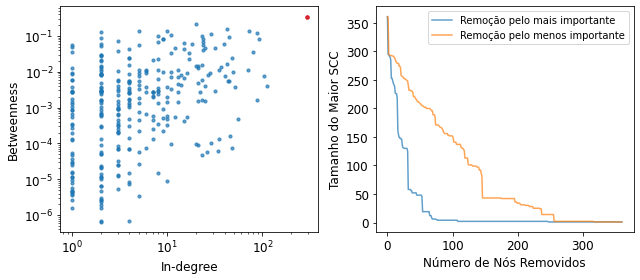

In [27]:
plt.figure(figsize=(9, 4))

# Plot 1: Scatter plot do rank versus betweenness centrality.
plt.subplot(1, 2, 1)
plt.scatter(nodes_in_degree, nodes_betweenss, s=10, alpha=0.7)
plt.scatter(max(nodes_in_degree), max(nodes_betweenss), s=13, alpha=0.7, color='r')
plt.xlabel('In-degree')
plt.ylabel("Betweenness")
plt.xscale('log')
plt.yscale('log')


#Plot 2: Graph resilience
plt.subplot(1, 2, 2)
removed_nodes = np.arange(len(subgraph))

plt.plot(removed_nodes, largest_scc_sizes, alpha=0.7, label='Remoção pelo mais importante')
plt.plot(removed_nodes, largest_scc_sizes2, alpha=0.7, label='Remoção pelo menos importante')

plt.xlabel("Número de Nós Removidos")
plt.ylabel("Tamanho do Maior SCC")
plt.legend()

plt.tight_layout()
plt.show()


### Clustering Coefficients

In [136]:
# Dict where keys are nodes and values are clustering coefficients
cluster_coefficients = nx.clustering(G)

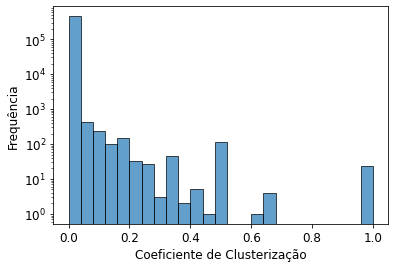

In [137]:
coefficients = list(cluster_coefficients.values())

# Histogram.
plt.figure(figsize=(6, 4))
plt.hist(coefficients, bins=25, alpha=0.7, edgecolor='k')
#plt.title("Distribuição dos Coeficientes de Clusterização")
plt.xlabel("Coeficiente de Clusterização")
plt.ylabel("Frequência")
plt.yscale('log')
plt.show()

In [138]:
print(f"Average Clustering Coefficient: {nx.average_clustering(G)}")

Average Clustering Coefficient: 0.0005117825383236345


### Distances

In [139]:
all_pairs_distances = dict(nx.all_pairs_shortest_path_length(G))

In [140]:
# Flatten distance matrix into list
all_distances = [dist for distances in all_pairs_distances.values() for dist in distances.values()]

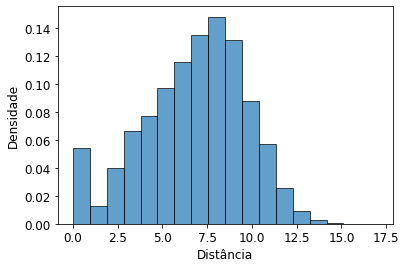

In [141]:
# Plot histogram.
plt.hist(all_distances, density=True, bins=18, alpha=0.7, edgecolor='k')
#plt.title("Distribuição das Distâncias de Todos os Nós")
plt.xlabel("Tamanho")
plt.ylabel("Densidade")
plt.show()

In [142]:
print(f"Average distance: {sum(all_distances) / len(all_distances)}")

Average distance: 6.662200674690858


### PageRank

In [102]:
pagerank = nx.pagerank(G)

In [104]:
sorted_nodes = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)

In [107]:
top_n = 10
top_nodes = sorted_nodes[:top_n]

# Crie um DataFrame com os nicknames e valores do PageRank.
data = {
    "Username": [G.nodes[node]['nickname'] for node, _ in top_nodes],
    "PageRank": [rank for _, rank in top_nodes]
}
df = pd.DataFrame(data)

# Exiba a tabela.
print(df)

          Username  PageRank
0  realDonaldTrump  0.000432
1   DonaldJTrumpJr  0.000067
2         catturd2  0.000062
3     DineshDSouza  0.000060
4     JackPosobiec  0.000058
5      TravisTritt  0.000049
6         dbongino  0.000037
7       DanScavino  0.000033
8       DevinNunes  0.000033
9        laralogan  0.000032


### Assortativity

In [173]:
in_assort_pearson = nx.degree_pearson_correlation_coefficient(G, x='in', y='in')

In [174]:
out_assort_pearson = nx.degree_pearson_correlation_coefficient(G, x='out', y='out')

In [177]:
# In-degree assortativity
in_degree_dict = dict(G.in_degree())
average_in_degrees = nx.average_neighbor_degree(G, source='in', target='in')
k_in = in_degree_dict.values()
knn_in = average_in_degrees.values()

# Out-degree assortativity
out_degree_dict = dict(G.out_degree())
average_out_degrees = nx.average_neighbor_degree(G, source='out', target='out')
k_out = out_degree_dict.values()
knn_out = average_out_degrees.values()

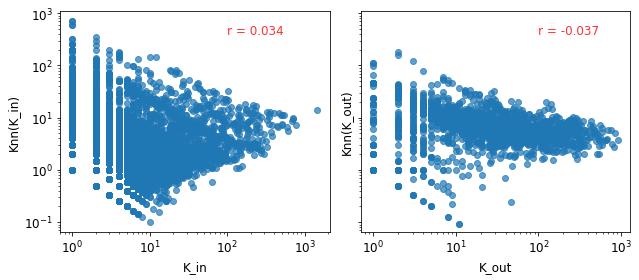

In [190]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax[0].scatter(k_in, knn_in, marker='o', alpha=0.7)
ax[0].text(100, 400, f'r = {in_assort_pearson:.3f}', fontsize=12, color='red', alpha=0.8)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel("K_in")
ax[0].set_ylabel("Knn(K_in)")

# Scatter plot of out degree distribution
ax[1].scatter(k_out, knn_out, marker='o', alpha=0.7)
ax[1].text(100, 400, f'r = {out_assort_pearson:.3f}', fontsize=12, color='red', alpha=0.8)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel("K_out")
ax[1].set_ylabel("Knn(K_out)")

plt.tight_layout()
plt.show()